# 📱 Phone Stock Predictor: Business Analytics Approach

Welcome to the **Phone Stock Predictor**! 

This tool helps resellers identify which phones to stock up on by analyzing historical market data. Unlike traditional review-level sentiment analysis, we use a **Phone-Level Aggregation** approach to evaluate the overall success of each model.

### 🚀 Key Features:
1.  **Phone-Level Aggregation**: We group reviews to calculate the average specs, ratings, and sentiment for each phone model.
2.  **Success Prediction**: We define a "Successful" phone as one with **High Sentiment** AND **High Popularity** (Sales Volume).
3.  **Contextual Scoring**: We combine the model's **Global Quality Score** with **Local Popularity** (based on your target Age/Country) to give tailored recommendations.
4.  **Sales Forecasting**: We predict next month's sales volume based on historical trends.
5.  **Business Insights**: Visualizing phones in a **Growth-Share Matrix** and **Sales Trend Lines**.

---


## 1. Import Libraries & Load Data
We start by importing necessary libraries and loading the dataset.

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_data(filepath):
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    
    # Currency Conversion (1 USD = 87 INR)
    EXCHANGE_RATE = 87.0
    df['price_inr'] = df['price_usd'] * EXCHANGE_RATE
    
    # Encode Sentiment for aggregation (Positive=1, Others=0)
    df['is_positive'] = df['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)
    
    # Parse Date
    df['review_date'] = pd.to_datetime(df['review_date'])
    df['month_year'] = df['review_date'].dt.to_period('M')
    
    return df

filepath = "Mobile Reviews Sentiment.csv"
raw_df = load_data(filepath)
print(f"Raw Data Shape: {raw_df.shape}")

Loading dataset...
Raw Data Shape: (50000, 28)


## 2. Phone-Level Aggregation
Instead of predicting on individual reviews, we aggregate data by `brand` and `model`. This gives us the "True Specs" and "Market Performance" of each phone.

**Aggregated Features:**
- `avg_price`: Average selling price.
- `avg_ratings`: Average of battery, camera, performance, etc.
- `sentiment_score`: % of Positive reviews (Quality Metric).
- `popularity`: Total number of reviews (Sales Volume Proxy).

In [19]:
# Aggregate by Brand and Model
phone_stats = raw_df.groupby(['brand', 'model']).agg({
    'price_inr': 'mean',
    'battery_life_rating': 'mean',
    'camera_rating': 'mean',
    'performance_rating': 'mean',
    'design_rating': 'mean',
    'display_rating': 'mean',
    'is_positive': 'mean',  # This becomes our Sentiment Score (0.0 to 1.0)
    'review_id': 'count'    # This is our Popularity (Review Count)
}).reset_index()

phone_stats.rename(columns={'is_positive': 'sentiment_score', 'review_id': 'popularity'}, inplace=True)

print(f"Aggregated Phone Models: {phone_stats.shape[0]}")
display(phone_stats.head())

Aggregated Phone Models: 22


,brand,model,price_inr,battery_life_rating,camera_rating,performance_rating,design_rating,display_rating,sentiment_score,popularity
0,Apple,iPhone 13,96421.026655,2.754952,2.754952,2.765139,2.765139,2.710243,0.568195,1767
1,Apple,iPhone 14,95644.151158,2.738255,2.781879,2.723714,2.773490,2.758949,0.567673,1788
2,Apple,iPhone 15 Pro,96025.310613,2.677635,2.707195,2.661461,2.675404,2.691021,0.532069,1793
3,Apple,iPhone SE,95970.871303,2.727728,2.703786,2.732183,2.690980,2.735523,0.543430,1796
4,Google,Pixel 6,70295.493871,2.712064,2.709962,2.689786,2.706179,2.715427,0.558218,2379


## 3. Define "Success" Target
To train a model, we need to define what a "Stock Worthy" phone is. 

**Definition:** A phone is successful if:
1.  **High Quality**: Sentiment Score > 75th Percentile
2.  **High Demand**: Popularity > 50th Percentile

This creates a binary target `is_successful` (1 = Yes, 0 = No).

In [20]:
# Define Thresholds
sentiment_threshold = phone_stats['sentiment_score'].quantile(0.75)
popularity_threshold = phone_stats['popularity'].quantile(0.50)

print(f"Success Thresholds -> Sentiment > {sentiment_threshold:.2f}, Popularity > {popularity_threshold:.0f}")

# Create Target Label
phone_stats['is_successful'] = ((phone_stats['sentiment_score'] > sentiment_threshold) & 
                                (phone_stats['popularity'] > popularity_threshold)).astype(int)

print("Class Distribution:")
print(phone_stats['is_successful'].value_counts())

Success Thresholds -> Sentiment > 0.56, Popularity > 2338
Class Distribution:
is_successful
0    18
1     4
Name: count, dtype: int64


## 4. Train Classification Model
We train a **Random Forest Classifier** to predict if a phone is "Successful" based on its specs (Price, Ratings, Brand).

**Why?** This allows us to score *any* phone (even with low data) based on its characteristics.

In [21]:
# Prepare Features
le_brand = LabelEncoder()
phone_stats['brand_encoded'] = le_brand.fit_transform(phone_stats['brand'])

feature_cols = ['brand_encoded', 'price_inr', 'battery_life_rating', 'camera_rating', 
                'performance_rating', 'design_rating', 'display_rating']

X = phone_stats[feature_cols]
y = phone_stats['is_successful']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, preds):.2%}")
print(classification_report(y_test, preds))

Model Accuracy: 60.00%
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5



## 5. Sales Forecasting Logic
We analyze the monthly review counts to predict future sales volume.

**Method:**
1.  Aggregate reviews by month for a specific phone model.
2.  Fit a **Linear Regression** trend line to the monthly counts.
3.  Predict the count for the next month.

In [22]:
def forecast_sales(model_name, raw_df):
    # 1. Filter data for the model
    model_data = raw_df[raw_df['model'] == model_name].copy()
    
    if model_data.empty:
        return 0, None
    
    # 2. Aggregate by Month
    monthly_sales = model_data.groupby('month_year').size().reset_index(name='sales')
    monthly_sales['month_index'] = np.arange(len(monthly_sales))
    
    # 3. Train Linear Trend Model
    if len(monthly_sales) < 2:
        return monthly_sales['sales'].mean(), monthly_sales # Not enough data for trend
        
    X = monthly_sales[['month_index']]
    y = monthly_sales['sales']
    
    trend_model = LinearRegression()
    trend_model.fit(X, y)
    
    # 4. Predict Next Month
    next_month_index = len(monthly_sales)
    next_month_sales = trend_model.predict([[next_month_index]])[0]
    
    return max(0, next_month_sales), monthly_sales

## 6. Interactive Recommendation System
Now we combine the model's **Global Quality Prediction** with **Local Market Data** and **Sales Forecasts**.

**Logic:**
1.  **Filter**: Get reviews for the specific Age Group (+/- 3 years) and Country.
2.  **Local Popularity**: Calculate market share in this specific demographic.
3.  **Global Quality**: Use the trained model to get the probability of success.
4.  **Forecast**: Predict next month's sales for top candidates.
5.  **Final Score**: Weighted Average (0.7 * Quality + 0.3 * Local Popularity).

--- User Input ---
Available Countries: Australia, Brazil, Canada, Germany, India, UAE, UK, USA

--- 🔍 Analysis for Age 30, Country India, Budget ₹60000 ---

🏆 Top 5 Recommended Phones to Stock:


,brand,model,price_inr,global_quality,local_popularity,final_score,next_month_forecast
5,OnePlus,OnePlus Nord 3,58675.133282,0.630000,0.050737,0.456221,65.504505
3,OnePlus,OnePlus 11R,58533.017139,0.130000,0.037758,0.102327,67.918919
9,Xiaomi,Poco X6,39168.354157,0.100000,0.055457,0.086637,64.072072
6,Realme,Realme 12 Pro,34257.169960,0.090000,0.074926,0.085478,98.045045
7,Realme,Realme Narzo 70,34163.306088,0.080000,0.074336,0.078301,100.166667


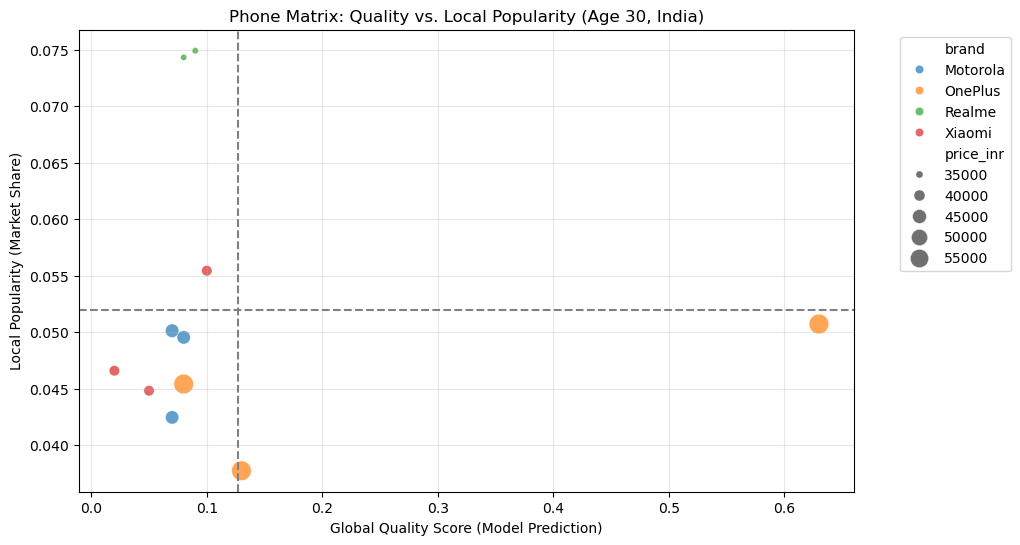


📈 Sales Trend for Top Recommendation: OnePlus Nord 3


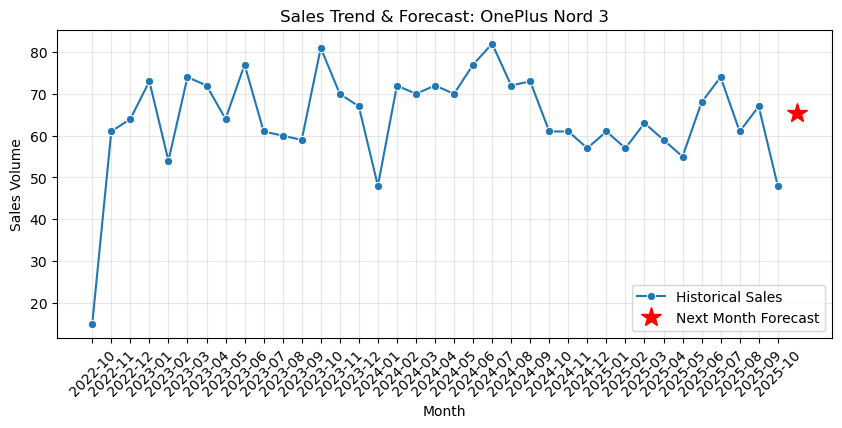

In [23]:
def get_recommendations(user_age, user_country, user_budget, raw_df, phone_stats, model, le_brand):
    print(f"\n--- 🔍 Analysis for Age {user_age}, Country {user_country}, Budget ₹{user_budget:.0f} ---")
    
    # 1. Filter Candidates by Budget
    candidates = phone_stats[phone_stats['price_inr'] <= user_budget].copy()
    
    if candidates.empty:
        print("❌ No phones found within budget.")
        return None, None
    
    # 2. Calculate Global Quality Score (Model Probability)
    X_pred = candidates[['brand_encoded', 'price_inr', 'battery_life_rating', 'camera_rating', 
                         'performance_rating', 'design_rating', 'display_rating']]
    
    # Probability of being class 1 (Successful)
    candidates['global_quality'] = model.predict_proba(X_pred)[:, 1]
    
    # 3. Calculate Local Popularity (Demographic Specific)
    age_min, age_max = user_age - 3, user_age + 3
    local_reviews = raw_df[(raw_df['country'] == user_country) & 
                           (raw_df['age'] >= age_min) & 
                           (raw_df['age'] <= age_max)]
    
    if local_reviews.empty:
        print("⚠️ No local data for this demographic. Relying on Global Quality.")
        candidates['local_popularity'] = 0
    else:
        local_counts = local_reviews['model'].value_counts().reset_index()
        local_counts.columns = ['model', 'local_count']
        total_local = len(local_reviews)
        local_counts['local_popularity'] = local_counts['local_count'] / total_local
        
        # Merge back to candidates
        candidates = candidates.merge(local_counts, on='model', how='left')
        candidates['local_popularity'] = candidates['local_popularity'].fillna(0)
    
    # 4. Final Weighted Score
    candidates['final_score'] = (0.7 * candidates['global_quality']) + (0.3 * candidates['local_popularity'])
    
    # 5. Add Forecasts for Top Candidates
    # We calculate forecast for ALL candidates to display in table, but visualization only for top 1
    candidates['next_month_forecast'] = candidates['model'].apply(lambda x: forecast_sales(x, raw_df)[0])

    # Sort and Display
    top_phones = candidates.sort_values(by='final_score', ascending=False).head(5)
    
    print("\n🏆 Top 5 Recommended Phones to Stock:")
    display_cols = ['brand', 'model', 'price_inr', 'global_quality', 'local_popularity', 'final_score', 'next_month_forecast']
    display(top_phones[display_cols].style.background_gradient(subset=['final_score'], cmap='Greens'))
    
    return top_phones, candidates

# Interactive Input
try:
    print("--- User Input ---")
    age = int(input("Enter Target Customer Age (e.g., 25): "))
    
    available_countries = sorted(raw_df['country'].unique())
    print(f"Available Countries: {', '.join(available_countries)}")
    country = input("Enter Target Country: ").strip()
    
    budget = float(input("Enter Maximum Budget (INR): "))
    
    if country not in available_countries:
        print("⚠️ Invalid country. Defaulting to 'India'.")
        country = "India"
        
    top_5, all_candidates = get_recommendations(age, country, budget, raw_df, phone_stats, model, le_brand)
    
    if top_5 is not None and not top_5.empty:
        # --- Visualization 1: Growth-Share Matrix ---
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=all_candidates, x='global_quality', y='local_popularity', 
                        hue='brand', size='price_inr', sizes=(20, 200), alpha=0.7)
        
        plt.axhline(y=all_candidates['local_popularity'].mean(), color='gray', linestyle='--')
        plt.axvline(x=all_candidates['global_quality'].mean(), color='gray', linestyle='--')
        
        plt.title(f'Phone Matrix: Quality vs. Local Popularity (Age {age}, {country})')
        plt.xlabel('Global Quality Score (Model Prediction)')
        plt.ylabel('Local Popularity (Market Share)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # --- Visualization 2: Sales Forecast Trend ---
        best_phone = top_5.iloc[0]['model']
        print(f"\n📈 Sales Trend for Top Recommendation: {best_phone}")
        
        _, history = forecast_sales(best_phone, raw_df)
        if history is not None:
            plt.figure(figsize=(10, 4))
            # Convert period to string for plotting
            history['month_str'] = history['month_year'].astype(str)
            sns.lineplot(data=history, x='month_str', y='sales', marker='o', label='Historical Sales')
            
            # Plot forecast point
            next_month_val = top_5.iloc[0]['next_month_forecast']
            plt.plot(len(history), next_month_val, 'r*', markersize=15, label='Next Month Forecast')
            
            plt.title(f'Sales Trend & Forecast: {best_phone}')
            plt.xlabel('Month')
            plt.ylabel('Sales Volume')
            plt.xticks(rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        
except ValueError:
    print("❌ Invalid input. Please enter numbers for Age and Budget.")